In [26]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab import evaluate_agent, multiConstAction, simulator
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from huggingface_hub import hf_hub_download
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO

## Monthly Environment Simulation

In [28]:
def evaluateConstAct(x):
    config = {
        'action_reward_scale': np.array([0.08, 0.08, 0.4]),
        'max_action': 3000,
        # 'env_stoch': 0.,
        'trapm_pmax': 10 * 0.1 * 2.75e-5, #2.26e-6,
        'trapf_pmax': 10 * 0.03 * 2.75e-5, #8.3e-7,
        'traps_pmax': 10 * 2.75e-5, #2.75e-5,

        'loss_a': 0.2,
        'loss_b': 5,
        'loss_c': 5,
        
        'action_reward_exponent': 10,
    }
    env = greenCrabMonthEnv()
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    
    return - m_reward

In [30]:
%%time
max_action = 3000
res = gp_minimize(evaluateConstAct, 3*[(0.0, max_action)], n_calls = 100, verbose=True)
res.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2882
Function value obtained: 9.2813
Current minimum: 9.2813
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2701
Function value obtained: 4.7252
Current minimum: 4.7252
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2746
Function value obtained: 16.7148
Current minimum: 4.7252
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2641
Function value obtained: 2.1392
Current minimum: 2.1392
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2817
Function value obtained: 0.1604
Current minimum: 0.1604
Iteration No: 6 started. Evaluatin

[1414.4236270946017, 1409.9248108232969, 1221.8633619032805]

In [14]:
# with nonNormalized env
evaluateConstAct(
    [1159.3031132772392, 1184.1524632666515, 1259.4498917568628]
)

0.08643379909223413

In [31]:
import ray
ray.shutdown()

In [4]:
env = greenCrabMonthEnv()
agent = multiConstAction(env=env, action=np.array([1159.3031132772392, 1184.1524632666515, 1259.4498917568628]))
constantData = simulator(env = env, agent = agent).simulate_full_named_obs_acts()
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,0.0,1159.303113,1184.152463,1259.449892,0.000000,0
1,1,0.0,1159.303113,1184.152463,1259.449892,-0.000143,0
2,2,0.0,1159.303113,1184.152463,1259.449892,-0.000285,0
3,3,0.0,1159.303113,1184.152463,1259.449892,-0.000428,0
4,4,0.0,1159.303113,1184.152463,1259.449892,-0.000570,0


<Axes: xlabel='t'>

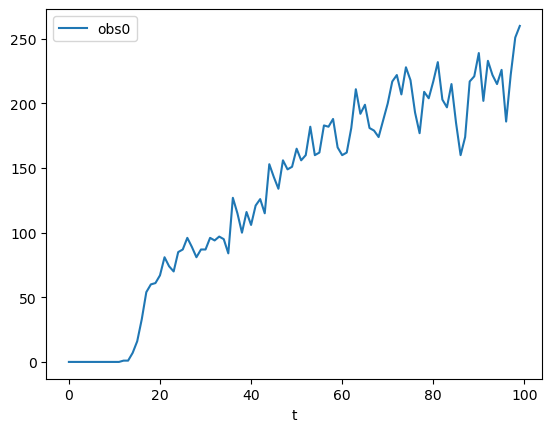

In [5]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

In [6]:
def environment_simulation(env, agent, reps=10, obs_names = None, acts_names = None):
    num_obs = np.prod(env.observation_space.shape)
    num_acts = np.prod(env.action_space.shape)
    obs_names = obs_names or [f'obs{i}' for i in range(num_obs)]
    acts_names = acts_names or [f'act{i}' for i in range(num_acts)]
    #
    data = {
        't': [],
        **{obsn: [] for obsn in obs_names},
        **{actn: [] for actn in acts_names},
        'rew': [],
        'rep': [],
        'crab_pop':[]
    }
    env = env
    agent = agent
    for rep in range(reps): # try score as average of 100 replicates, still a noisy measure
        episode_reward = 0.0
        observation, _ = env.reset()
        for t in range(env.Tmax):
            action, _ = agent.predict(observation, deterministic=True)
            #
            data['rew'].append(episode_reward)
            data['rep'].append(rep)
            data['t'].append(t)
            data['crab_pop'].append(env.state)
            for idx, obs_name in enumerate(obs_names):
                data[obs_name].append(observation[idx])
            for idx, act_name in enumerate(acts_names):
                data[act_name].append(action[idx])
            #
            observation, reward, terminated, done, info = env.step(action)
            episode_reward += reward
            #
            if terminated or done:
                break
    return data

In [7]:
agent = multiConstAction(env=env, action=np.array([0, 0, 0]))
constantData = environment_simulation(env, agent)
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,act0,act1,act2,rew,rep,crab_pop
0,0,0.0,0,0,0,0.000000,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,0.0,0,0,0,-0.003379,0,"[10.132375360797672, 225.8567578852788, 921.34..."
2,2,0.0,0,0,0,-0.006351,0,"[4.970467148436807, 92.8716399820499, 482.9856..."
3,3,0.0,0,0,0,-0.008967,0,"[2.134437260485081, 39.23893673658648, 244.246..."
4,4,0.0,0,0,0,-0.011292,0,"[0.9939239357333701, 16.832227474919236, 120.3..."


In [8]:
crab_pop_df = pd.DataFrame(constantDataDF[constantDataDF['rep']==0]['crab_pop'].tolist(), columns=[f'crab_pop_{i}' for i in range(len(constantDataDF['crab_pop'][0]))])
crab_pop_df['t'] = constantDataDF['t']
crab_pop_df

,crab_pop_0,crab_pop_1,crab_pop_2,crab_pop_3,crab_pop_4,crab_pop_5,crab_pop_6,crab_pop_7,crab_pop_8,crab_pop_9,...,crab_pop_12,crab_pop_13,crab_pop_14,crab_pop_15,crab_pop_16,crab_pop_17,crab_pop_18,crab_pop_19,crab_pop_20,t
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0
1,10.132375,225.856758,921.340346,1307.743958,727.289201,337.958230,513.815628,650.805013,538.050540,300.614729,...,20.465621,9.418167,3.532266,0.612549,0.010593,0.000005,5.508771e-11,0.000000e+00,0.000000,1
2,4.970467,92.871640,482.985623,1038.319372,1041.037389,577.745141,440.282561,576.059157,576.145887,398.914507,...,31.871131,12.911575,4.830099,0.909137,0.015885,0.000008,8.263157e-11,0.000000e+00,0.000000,2
3,2.134437,39.238937,244.246037,691.729281,1008.716881,825.375195,530.575853,519.087865,571.060257,467.147712,...,49.394828,18.136000,6.167224,1.205751,0.021176,0.000010,1.101754e-10,0.000000e+00,0.000000,3
4,0.993924,16.832227,120.305116,424.020491,809.261890,905.563490,688.215214,535.515007,548.152065,508.049891,...,76.365250,28.358920,9.799777,2.468085,0.292826,0.004322,1.856123e-06,1.714151e-11,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.603216,13.526805,108.848323,448.666916,1076.309350,1565.133059,1474.631038,1106.349406,980.051427,1063.748209,...,1043.158112,1040.112491,1045.659239,1032.279447,979.876056,887.978732,7.363844e+02,5.158455e+02,256.894729,95
96,0.120071,5.725589,52.976990,254.214489,723.069569,1286.103262,1504.796805,1288.599869,1053.087132,1042.834959,...,1060.519827,1049.878683,1043.898844,1035.045673,991.953492,900.495565,7.461023e+02,5.228896e+02,260.222872,96
97,0.046241,2.276222,23.899872,137.520553,460.439961,973.282811,1376.883615,1393.093290,1177.046061,1063.848388,...,1081.009215,1054.777336,1050.744737,1039.674510,1004.482702,910.520321,7.433540e+02,5.239794e+02,263.475046,97
98,2.683571,3126.581944,3141.581944,105.683571,381.000000,815.000000,1151.000000,1212.000000,1040.000000,932.000000,...,982.000000,954.000000,963.000000,962.000000,922.000000,843.000000,6.860000e+02,4.840000e+02,242.000000,98


In [9]:
def plot_selected_sizes(expanded_df:pd.DataFrame, selected_sizes):
    plt.figure(figsize=(12, 8))
    time = expanded_df['t']  # Time column

    # If no sizes selected, show a placeholder message
    if not selected_sizes:
        plt.text(0.5, 0.5, 'No sizes selected', fontsize=20, ha='center', va='center')
        plt.axis('off')
        plt.show()
        return

    # Plot each selected size
    for col in selected_sizes:
        plt.plot(time, expanded_df[col], label=col)

    # Customize the plot
    plt.title("Green Crab Population Change Over Time", fontsize=16)
    plt.xlabel("Time (t)", fontsize=14)
    plt.ylabel("Population", fontsize=14)
    plt.legend(title="Crab Sizes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()

    # Show the plot
    plt.show()

# Create a multi-select widget for crab size columns
crab_pop_columns = [col for col in crab_pop_df.columns if col.startswith('crab_pop_')]
size_selector = widgets.SelectMultiple(
    options=crab_pop_columns,
    value=[crab_pop_columns[0]],  # Default selection
    description='Sizes',
    disabled=False
)
# Create an interactive plot
interact(lambda selected_sizes: plot_selected_sizes(crab_pop_df, selected_sizes), selected_sizes=size_selector);

interactive(children=(SelectMultiple(description='Sizes', index=(0,), options=('crab_pop_0', 'crab_pop_1', 'cr…

### normalized environment

In [2]:
env = greenCrabMonthEnvNormalized()
agent = multiConstAction(env=env, action=np.array([-0.22713126, -0.21056502, -0.16036674]))

In [34]:
def evaluateConstAct(x):
    env = greenCrabMonthEnvNormalized()
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    
    return - m_reward

In [35]:
# normalized constant action
def normalized_action(act, max_act):
    max_action = max_act
    constant_act = np.array(act)
    return constant_act * 2 / max_action - 1 

In [39]:
normalized_action([1159.3031132772392, 1184.1524632666515, 1259.4498917568628], max_action)

array([-0.22713126, -0.21056502, -0.16036674])

In [5]:
evaluateConstAct([-0.22713126, -0.21056502, -0.16036674])

2025-01-09 05:28:52,049	INFO worker.py:1821 -- Started a local Ray instance.


1.4855454771582828

In [40]:
import ray
ray.shutdown()

In [7]:
constantData = simulator(env = env, agent = agent).simulate_full_named_obs_acts()
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,-1.0,-0.227131,-0.210565,-0.160367,0.000000,0
1,1,-1.0,-0.227131,-0.210565,-0.160367,-0.001426,0
2,2,-1.0,-0.227131,-0.210565,-0.160367,-0.002852,0
3,3,-1.0,-0.227131,-0.210565,-0.160367,-0.004277,0
4,4,-1.0,-0.227131,-0.210565,-0.160367,-0.005703,0


<Axes: xlabel='t'>

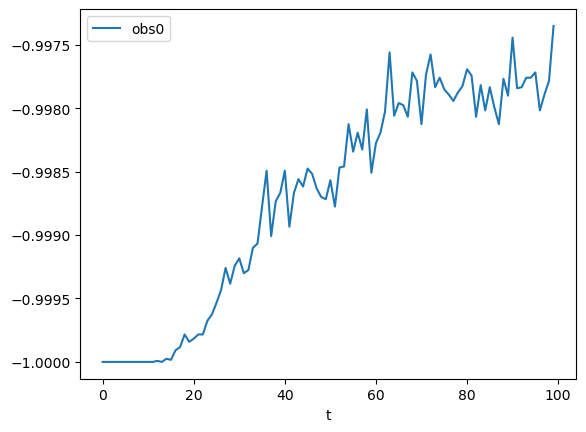

In [8]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

## Loading and evaluating trained models

In [11]:
repo_id = "jimjiang203/greencrabPPO"
td3_path = hf_hub_download(repo_id=repo_id, filename='td3_gcmonthnorm.zip')
ppo_path = hf_hub_download(repo_id=repo_id, filename='PPO_gcmenorm.zip')
reppo_path = hf_hub_download(repo_id=repo_id, filename='RecurrentPPO_gcmenorm.zip')
tqc_path = hf_hub_download(repo_id=repo_id, filename='TQC_gcmenorm.zip')

PPO_gcmenorm.zip:   0%|          | 0.00/140k [00:00<?, ?B/s]

RecurrentPPO_gcmenorm.zip:   0%|          | 0.00/6.90M [00:00<?, ?B/s]

TQC_gcmenorm.zip:   0%|          | 0.00/3.21M [00:00<?, ?B/s]

In [4]:
evalEnv = greenCrabMonthEnvNormalized()

In [6]:
td3Agent = TD3.load("study_results/tunning_best_gcmonthnorm_TD3", device="cpu")
ppoAgent = PPO.load("PPO_gcmenorm", device="cpu")
tqcAgent = TQC.load("TQC_gcmenorm", device="cpu")
recurrentPPOAgent = RecurrentPPO.load("RecurrentPPO_gcmenorm", device="cpu")

In [11]:
N_EPS = 200

ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

In [13]:
import ray
ray.shutdown()

In [12]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
""")


PPO mean rew = -1.4695712653836006
TQC mean rew = -1.403712970434758
TD3 mean rew = -1.6545957414496935
RecurrentPPO mean rew = -1.4117802084892432



### RecurrentPPO plot

In [15]:
reppoData = simulator(env = evalEnv, agent = recurrentPPOAgent).simulate_full_named_obs_acts()
reppoDataDF = pd.DataFrame(reppoData)
reppoDataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,-1.000000,-0.061992,-0.403807,-0.045986,0.000000,0
1,1,-0.997798,-0.062021,-0.403805,-0.045978,-0.038008,0
2,2,-0.997765,-0.062021,-0.403805,-0.045978,-0.066700,0
3,3,-0.997685,-0.062022,-0.403805,-0.045978,-0.088148,0
4,4,-0.997878,-0.062020,-0.403805,-0.045978,-0.104876,0


<Axes: xlabel='t'>

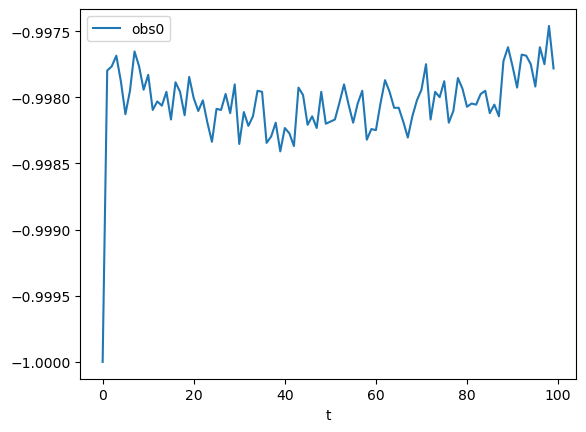

In [16]:
reppoDataDF[reppoDataDF.rep == 0].plot(x='t', y =['obs0'])